In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [114]:
import re
# 格式为[ type, ...]
def get_lin_type(type_list):
    return_list = []
    for i in range(len(type_list)-1):
        if type_list[i] == 'para' and type_list[i+1] == 'para':
            return_list.append(1)
        else:
            return_list.append(0)
    return_list.append(0)
    return return_list

# 格式为[text, ...]
def next_is_shiyong(text):
    return_list = []
    for i in range(len(text)-1):
        if re.search('^□.*√.*', str(text[i+1])):
            return_list.append(1)
        else:
            return_list.append(0)
    return_list.append(0)
    return return_list

In [121]:
file1 = pd.read_csv('model5_return已标注段落.csv',encoding='gbk')
file1['is_continue'] = get_lin_type(file1['type'].values)
file1['is_next_shiyong'] = next_is_shiyong(file1['text'].values)
file1 = file1.loc[file1['type']=='para']
for i in ['x0','x1','y0','y1','top','bottom','doctop','size','height','width','adv']:
    new_data = file1[i].tolist()[1:]
    new_data.append(0)
    file1[i+'_next'] = new_data
    
file2 = pd.read_csv('model6_return段落已标注.csv',encoding='gbk')
file2['is_continue'] = get_lin_type(file2['type'].values)
file2['is_next_shiyong'] = next_is_shiyong(file2['text'].values)
file2 = file2.loc[file2['type']=='para']
for i in ['x0','x1','y0','y1','top','bottom','doctop','size','height','width','adv']:
    new_data = file2[i].tolist()[1:]
    new_data.append(0)
    file2[i+'_next'] = new_data
    
file3 = pd.read_csv('model8_return修正.csv',encoding='gbk')   
file3['is_continue'] = get_lin_type(file3['type'].values)
file3['is_next_shiyong'] = next_is_shiyong(file3['text'].values)
file3 = file3.loc[file3['type'] == 'para']
file3['continue'] = file3.apply(lambda x:x['is_para'] if str(x['xiuzheng']) == 'nan' else x['xiuzheng'], axis=1)
file3.drop(['xiuzheng','is_para'], inplace=True, axis=1)
file3 = file3.loc[file3['type']=='para']
for i in ['x0','x1','y0','y1','top','bottom','doctop','size','height','width','adv']:
    new_data = file3[i].tolist()[1:]
    new_data.append(0)
    file3[i+'_next'] = new_data
    
file = pd.concat([file1,file2,file3])

/home/sunday/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [122]:
file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692 entries, 0 to 2606
Data columns (total 35 columns):
Unnamed: 0            692 non-null int64
adv                   692 non-null float64
adv_next              692 non-null float64
bottom                692 non-null float64
bottom_next           692 non-null float64
cod                   692 non-null int64
continue              692 non-null float64
doctop                692 non-null float64
doctop_next           692 non-null float64
fontname              692 non-null object
height                692 non-null float64
height_next           692 non-null float64
is_continue           692 non-null int64
is_next_shiyong       692 non-null int64
non_stroking_color    692 non-null object
object_type           692 non-null object
page_number           692 non-null float64
size                  692 non-null float64
size_next             692 non-null float64
stroking_color        521 non-null object
text                  692 non-null object
top 

In [123]:
para_data = file.loc[file['type']=='para']
#file_next_value = para_data[['x0','x1','y0','y1','top','bottom','doctop','size','height','width','adv']]
#file_next_value.rename(columns = {
#    'x0':'x2','x1':'x3','y0':'y2','y1':'y3','top':'top1','bottom':'bottom1','size':'size1',
#    'height':'height1','width':'width1','adv':'adv1'
#}, inplace=True)


In [124]:
para_data['len_str'] = para_data['text'].apply(lambda x:len(x))

In [125]:
para_data['is_mulu'] = para_data['text'].apply(lambda x:1 if '......' in x else 0)

In [126]:
para_data.head()

,Unnamed: 0,adv,adv_next,bottom,bottom_next,cod,continue,doctop,doctop_next,fontname,...,x0,x0_next,x1,x1_next,y0,y0_next,y1,y1_next,len_str,is_mulu
0,0,1.00,1.00,207.277,238.477,0,0.0,187.297,218.497,ZWIVFZ+FangSong,...,136.980,257.460,156.960,277.440,634.643,603.443,654.623,623.423,16,0
1,1,1.00,1.00,238.477,269.677,1,0.0,218.497,249.697,ZWIVFZ+FangSong,...,257.460,219.720,277.440,239.700,603.443,572.243,623.423,592.223,4,0
2,2,1.00,0.25,269.677,272.953,2,0.0,249.697,252.973,ZWIVFZ+FangSong,...,219.720,174.723,239.700,425.535,572.243,568.958,592.223,588.947,10,0
3,3,0.25,1.00,272.953,407.987,3,0.0,252.973,391.967,TimesNewRomanPS-BoldMT,...,174.723,169.140,425.535,185.160,568.958,431.305,588.947,447.325,4,0
4,4,1.00,1.00,407.987,433.188,4,0.0,391.967,421.188,ZWIVFZ+FangSong,...,169.140,192.660,185.160,204.660,431.305,407.016,447.325,419.016,16,0


In [127]:
para_data.columns

Index(['Unnamed: 0', 'adv', 'adv_next', 'bottom', 'bottom_next', 'cod',
       'continue', 'doctop', 'doctop_next', 'fontname', 'height',
       'height_next', 'is_continue', 'is_next_shiyong', 'non_stroking_color',
       'object_type', 'page_number', 'size', 'size_next', 'stroking_color',
       'text', 'top', 'top_next', 'type', 'upright', 'width', 'width_next',
       'x0', 'x0_next', 'x1', 'x1_next', 'y0', 'y0_next', 'y1', 'y1_next',
       'len_str', 'is_mulu'],
      dtype='object')

In [128]:
para_data.drop(['Unnamed: 0','fontname','text','object_type','upright','type','cod','page_number'],axis=1,inplace=True)

In [129]:
para_data.drop(['non_stroking_color','stroking_color'],axis=1,inplace=True)

In [16]:
# 归一化处理
clf = MinMaxScaler().fit_transform(para_data[['bottom', 'doctop', 'height', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next']])

para_data[['bottom', 'doctop', 'height', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next']] = clf


/home/sunday/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/sunday/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [130]:
para_data.head()

,adv,adv_next,bottom,bottom_next,continue,doctop,doctop_next,height,height_next,is_continue,...,x0,x0_next,x1,x1_next,y0,y0_next,y1,y1_next,len_str,is_mulu
0,1.00,1.00,207.277,238.477,0.0,187.297,218.497,19.98,19.98,1,...,136.980,257.460,156.960,277.440,634.643,603.443,654.623,623.423,16,0
1,1.00,1.00,238.477,269.677,0.0,218.497,249.697,19.98,19.98,1,...,257.460,219.720,277.440,239.700,603.443,572.243,623.423,592.223,4,0
2,1.00,0.25,269.677,272.953,0.0,249.697,252.973,19.98,19.98,1,...,219.720,174.723,239.700,425.535,572.243,568.958,592.223,588.947,10,0
3,0.25,1.00,272.953,407.987,0.0,252.973,391.967,19.98,16.02,1,...,174.723,169.140,425.535,185.160,568.958,431.305,588.947,447.325,4,0
4,1.00,1.00,407.987,433.188,0.0,391.967,421.188,16.02,12.00,1,...,169.140,192.660,185.160,204.660,431.305,407.016,447.325,419.016,16,0


In [131]:
y_file = para_data['continue']
x_file = para_data.drop('continue', axis=1)

0.8984520764827669


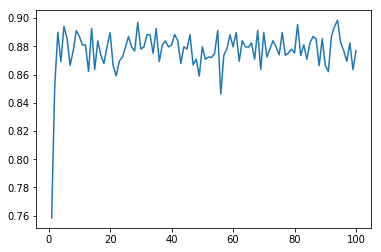

In [132]:
score_list = []

for i in range(100):
    clf = RandomForestClassifier(max_depth=1+i,criterion='entropy')
    score = cross_val_score(clf,x_file, y_file, cv =10)
    score_list.append(score.mean())
    
print(max(score_list))
plt.plot(range(1,101),score_list)
plt.show()

0.9174199244915358


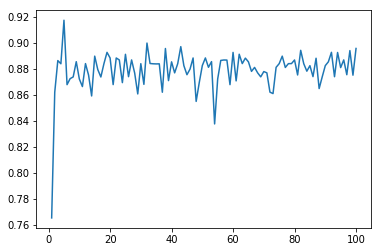

In [133]:
score_list = []

for i in range(100):
    clf = RandomForestClassifier(max_depth=1+i,criterion='gini')
    score = cross_val_score(clf,x_file, y_file, cv =10)
    score_list.append(score.mean())
    
print(max(score_list))
plt.plot(range(1,101),score_list)
plt.show()

In [138]:
parameters = {
    'n_estimators':[*range(1,20)],
    'max_features':[*range(1,20)],
    #'criterion':['gini'],
    'max_depth':[*range(1,10)],
    #'max_features':['auto','sqrt','log2',None],
    #'min_samples_split':[*np.linspace(0.00000001,1,50)]
}


rfc = RandomForestClassifier()
gs = GridSearchCV(rfc, parameters, cv=10)

In [139]:
gs.fit(x_file,y_file)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [151]:
x_file.columns

Index(['adv', 'adv_next', 'bottom', 'bottom_next', 'doctop', 'doctop_next',
       'height', 'height_next', 'is_continue', 'is_next_shiyong', 'size',
       'size_next', 'top', 'top_next', 'width', 'width_next', 'x0', 'x0_next',
       'x1', 'x1_next', 'y0', 'y0_next', 'y1', 'y1_next', 'len_str',
       'is_mulu'],
      dtype='object')

In [140]:
gs.best_score_

0.9595375722543352

In [142]:
gs.best_params_

{'max_depth': 3, 'max_features': 14, 'n_estimators': 14}

In [150]:
joblib.dump(gs.best_estimator_, 'para.pkl')

['para.pkl']

In [144]:
from sklearn import svm

0.9420289855072463


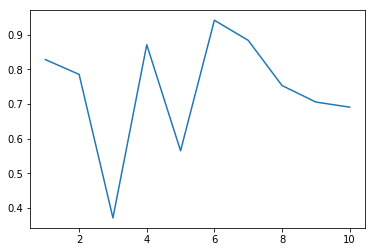

In [147]:
clf = svm.LinearSVC()
score = cross_val_score(clf,x_file, y_file, cv =10)
score
    
print(max(score))
plt.plot(range(1,11),score)
plt.show()

In [149]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=14, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [141]:
gs.best_params_

{'max_depth': 3, 'max_features': 14, 'n_estimators': 14}

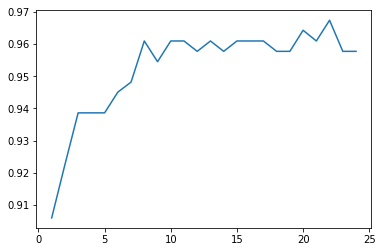

In [142]:
score_list = []

for i in range(1,25):
    rfc = RandomForestClassifier(max_depth=6, max_features=i, n_estimators=94)
    rfc = cross_val_score(rfc,x_file,y_file,cv=10)
    score_list.append(rfc.mean())

plt.plot(range(1,25),score_list)
plt.show()


In [143]:
max(score_list)

0.9674193548387097

In [144]:
len(score_list)

24

In [148]:
x_file.columns

Index(['adv', 'bottom', 'cod', 'doctop', 'height', 'page_number', 'size',
       'top', 'width', 'x0', 'x1', 'y0', 'y1', 'x0_next', 'x1_next', 'y0_next',
       'y1_next', 'top_next', 'bottom_next', 'doctop_next', 'size_next',
       'height_next', 'width_next', 'adv_next', 'len_str', 'is_mulu'],
      dtype='object')